### Make your own tracks, test how they function wrt one another

This is really about understanding networkx

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys,os,os.path
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

import numpy as np
import pandas as pd

In [3]:
from invisible_cities.cities.components import track_blob_info_creator_extractor
from invisible_cities.io.hits_io        import load_hits
from invisible_cities.io.hits_io        import hits_from_df
from invisible_cities.core              import system_of_units as units
from invisible_cities.types.symbols     import HitEnergy
from invisible_cities.evm.event_model   import HitCollection
from invisible_cities.evm.event_model   import Cluster
from invisible_cities.evm.event_model   import Hit
from invisible_cities.types.ic_types    import xy
from invisible_cities.reco.paolina_functions import voxelize_hits
import invisible_cities.reco.paolina_functions as plf

from   matplotlib.animation import FuncAnimation
import matplotlib.pyplot    as     plt
import matplotlib.colors    as     colors
import matplotlib.cm        as     cm
from matplotlib.colors import Normalize

In [4]:
def plot_voxels(df, base_vsize = 12):

    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)
    
    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)
    
    vsizex = voxels[0].size[0]
    vsizey = voxels[0].size[1]
    vsizez = voxels[0].size[2]

    min_corner_x = min(v.X for v in voxels) - vsizex/2.
    min_corner_y = min(v.Y for v in voxels) - vsizey/2.
    min_corner_z = min(v.Z for v in voxels) - vsizez/2.

    
    x = [np.round(v.X/vsizex) for v in voxels]
    y = [np.round(v.Y/vsizey) for v in voxels]
    z = [np.round(v.Z/vsizez) for v in voxels]
    e = [v.E for v in voxels]

    x_min = int(min(x))
    y_min = int(min(y))
    z_min = int(min(z))

    x_max = int(max(x))
    y_max = int(max(y))
    z_max = int(max(z))

    VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
    #print(VOXELS.shape)

    # sort through the event set the "turn on" the hit voxels
    cmap = cm.viridis
    norm = Normalize(vmin=0, vmax=max(e))

    colors = np.empty(VOXELS.shape, dtype=object)
    for q in range(0,len(z)):
        VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
        colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

    # and plot everything
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    #a,b,c is spacing in mm needs an extra dim
    a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
    a = a*vsizex + min_corner_x
    b = b*vsizey + min_corner_y
    c = c*vsizez + min_corner_z

    # a, b, c are the corners of the voxels
    ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

    ax.set_xlabel('x (mm)')#,fontsize=16)
    ax.set_ylabel('y (mm)')#,fontsize=16)
    ax.set_zlabel('z (mm)')#,fontsize=16)


    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm)
    cb.set_label('Energy (keV)')

    fig.suptitle('voxelised_plot_two_tracks')

    #ax.view_init(-160, 90)

    #plt.show(fig)

In [5]:
# create hit collection (look at how the tests do it, there are probably fixtures)
#ICTDIR = '/home/e78368jw/Documents/NEXT_CODE/IC/invisible_cities/'
#ICDATADIR = os.path.join(ICTDIR, "database/test_data/")
#hits_file_name = os.path.join(ICDATADIR, "Kr_hits_for_psf_0.h5")
#hits_file_name = '/home/e78368jw/Downloads/sophronia_1_208Tl.h5'
#hits = load_hits(hits_file_name)

In [6]:
tr_1 = []
for i in range(0, 5):
    z_1 = np.random.uniform(low = 1 * units.mm, high = 20 * units.mm)
    z_2 = np.random.uniform(low = 1 * units.mm, high = 20 * units.mm)
    e_1 = np.random.uniform(low = 1, high = 20)
    e_2 = np.random.uniform(low = 1, high = 20)
    tr_1.append([0, 1, (9 * i + 1) * units.mm, 0 * units.mm, z_1, 1, e_1, e_1])
    tr_1.append([0, 1, (9 * i + 1) * units.mm + 1, 30 * units.mm, z_2, 1, e_2, e_2])

data = pd.DataFrame(tr_1, columns = ['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'E', 'Ep'])

display(data)

,event,npeak,X,Y,Z,Q,E,Ep
0,0,1,1.0,0.0,18.040343,1,4.503115,4.503115
1,0,1,2.0,30.0,8.635205,1,11.768405,11.768405
2,0,1,10.0,0.0,19.877615,1,13.913750,13.913750
3,0,1,11.0,30.0,3.247856,1,13.927850,13.927850
4,0,1,19.0,0.0,16.303979,1,11.938374,11.938374
5,0,1,20.0,30.0,5.994732,1,6.005032,6.005032
6,0,1,28.0,0.0,19.448126,1,9.908381,9.908381
7,0,1,29.0,30.0,4.239531,1,12.908667,12.908667
8,0,1,37.0,0.0,15.886257,1,18.816786,18.816786
9,0,1,38.0,30.0,19.340728,1,2.626678,2.626678


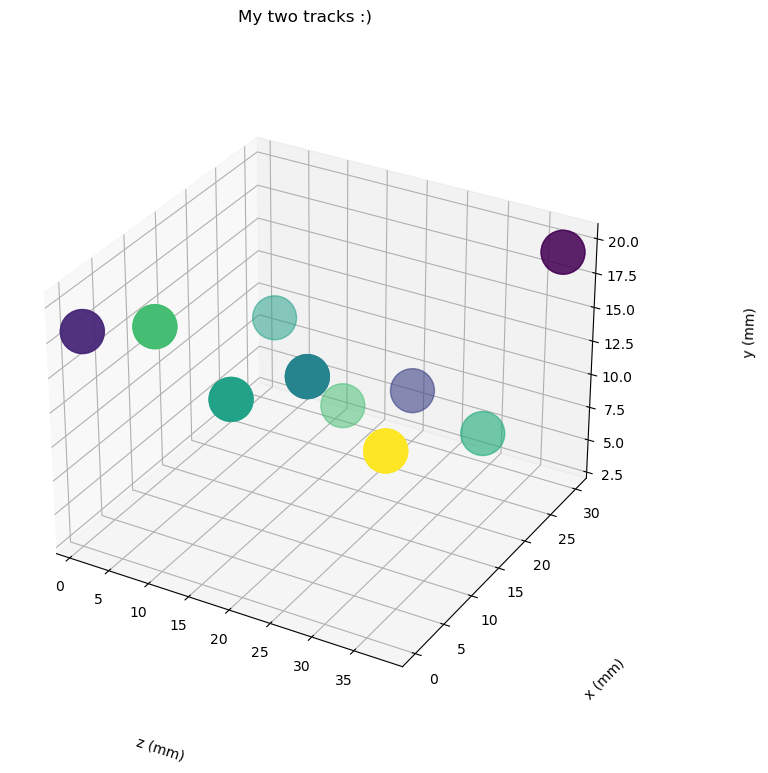

In [7]:
plt.ion()
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
for Y, df in data.groupby(['Y']):
    ax.scatter(data.X, data.Y, data.Z, c=data.E, s=1000, label = f'{Y}')
ax.set_xlabel("z (mm)", labelpad=50)
ax.set_ylabel("x (mm)", labelpad=50)
ax.set_zlabel("y (mm)", labelpad=50)
plt.suptitle("My two tracks :)")

plt.show()

/tmp/ipykernel_207809/3444354541.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


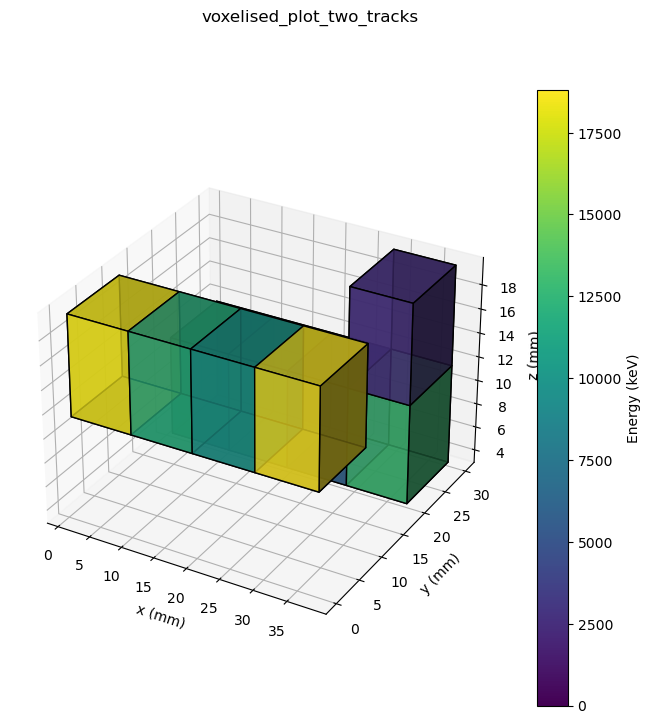

In [8]:
plot_voxels(data)

In [9]:
topological_creator = track_blob_info_creator_extractor((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        27 * units.mm,
                                                        1000000,
                                                        False
                                                        )

In [10]:
hits_lol = hits_from_df(data)

df, track_hitc, out_of_map = topological_creator(hits_lol[0])

Distance retrieved: {Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): {Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): 0, Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727): 9.250000000001501, Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825): 18.500000000003, Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834): 27.750000000004494}, Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727): {Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): 9.250000000001501, Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727): 0, Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825): 9.2500000000015, Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834): 18.500000000002995}, 

In [11]:
pd.options.display.max_columns = None
display(df)
display(track_hitc)
display(out_of_map)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,59.080406,27.750000,4,5,2,1.0,0.0,15.886257,1.000000,37.0,0.0,19.877615,37.000000,22.750783,0.0,17.672198,22.750783,5.625,5.0,15.720175,33.375,5.0,15.720175,37.0,0.0,15.886257,7.799406,0.0,19.428383,40.663541,40.263620,21.846755,9.25,10.0,8.31488
1,0,1,47.236633,30.937835,5,5,2,2.0,30.0,3.247856,30.066593,38.0,30.0,19.340728,48.414874,16.322267,30.0,6.105121,35.590522,5.625,25.0,7.405296,33.375,25.0,15.720175,2.0,30.0,8.635205,38.000000,30.0,19.340728,31.701288,21.540378,6.005032,9.25,10.0,8.31488


HitCollectionHit list:<Hit : npeak = 1.0 z = 16.303979266442354 XYpeak = -1000, -1000 E = 11.938373948274727 Ec = -1 Ep = 11.938373948274727 trackid = 0 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=19.0, y=0.0) 3dHit = Hit(19.0, 0.0, 16.303979266442354, E=11.938373948274727)  > ><Hit : npeak = 1.0 z = 19.44812554979788 XYpeak = -1000, -1000 E = 9.908381348259825 Ec = -1 Ep = 9.908381348259825 trackid = 0 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=28.0, y=0.0) 3dHit = Hit(28.0, 0.0, 19.44812554979788, E=9.908381348259825)  > ><Hit : npeak = 1.0 z = 18.040343451827987 XYpeak = -1000, -1000 E = 4.503114858814293 Ec = -1 Ep = 4.503114858814293 trackid = 0 cluster =< nsipm = -1 Q = 1.0
                    xy = xy(x=1.0, y=0.0) 3dHit = Hit(1.0, 0.0, 18.040343451827987, E=4.503114858814293)  > ><Hit : npeak = 1.0 z = 19.877615449799087 XYpeak = -1000, -1000 E = 13.91374964607399 Ec = -1 Ep = 13.91374964607399 trackid = 0 cluster =< nsipm = -1 Q = 1.0
          

False

### distance between the two tracks

testing

In [12]:
# collect the voxels
def voxelise(df, base_vsize = 12):
    xs = df.X
    ys = df.Y
    zs = df.Z
    es = df.E

    the_hits = []
    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                            np.array([base_vsize, base_vsize, base_vsize]), False)

    return voxels

In [13]:
voxels = voxelise(data)
print(voxels)

[Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828), Voxel(5.624999999997749, 25.000000000001997, 7.405295517933235, E=11.768405435577343), Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727), Voxel(14.87499999999925, 25.000000000001997, 7.405295517933235, E=13.927850032785981), Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825), Voxel(24.12500000000075, 25.000000000001997, 7.405295517933235, E=6.005032279794303), Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834), Voxel(33.375000000002245, 25.000000000001997, 7.405295517933235, E=12.908667007099153), Voxel(33.375000000002245, 25.000000000001997, 15.72017547251247, E=2.6266782823543076)]


In [14]:
# tracks from voxels
print(f"voxels: {voxels}")
mod_voxels, dropped_voxels = plf.drop_end_point_voxels(voxels, 0.001 * units.keV, 3)
print(f"mod_voxels: {mod_voxels}")
tracks = plf.make_track_graphs(mod_voxels)

display(tracks)

print(tracks[0].nodes())
print(list(tracks[0].nodes())[0])
print(list(tracks[0].nodes())[0].E)

voxels: [Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828), Voxel(5.624999999997749, 25.000000000001997, 7.405295517933235, E=11.768405435577343), Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727), Voxel(14.87499999999925, 25.000000000001997, 7.405295517933235, E=13.927850032785981), Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825), Voxel(24.12500000000075, 25.000000000001997, 7.405295517933235, E=6.005032279794303), Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834), Voxel(33.375000000002245, 25.000000000001997, 7.405295517933235, E=12.908667007099153), Voxel(33.375000000002245, 25.000000000001997, 15.72017547251247, E=2.6266782823543076)]
Distance retrieved: {Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): {Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): 0, Voxel(14.87499999

(<networkx.classes.graph.Graph at 0x79902f03ea00>,
 <networkx.classes.graph.Graph at 0x79902f03ec10>)

[Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825), Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727), Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834), Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828)]
Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825)
9.908381348259825


In [15]:
import networkx as nx

print(tracks[0])
print(tracks[0].nodes(data = True))
print(tracks[0].nodes.keys)
print(type(tracks[0].nodes))
print(list(tracks[0].nodes())[0].E)
print(type(tracks[0].nodes()))


# lets test minimum distance between these two here
#x = min(dist(v1, v2) for i, v1 in enumerate(tracks[0].nodes()) for v2 in tracks[1].nodes()[i:])

q = (iter(tracks[0].nodes))
print(next(q))
print(next(q))
print(next(q))
print(next(q))

Graph with 4 nodes and 3 edges
[(Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825), {}), (Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727), {}), (Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834), {}), (Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828), {})]
<bound method Mapping.keys of NodeView((Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825), Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727), Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834), Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828)))>
<class 'networkx.classes.reportviews.NodeView'>
9.908381348259825
<class 'networkx.classes.reportviews.NodeView'>
Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825)
Voxel(14.874999999

In [16]:
for node, data in tracks[0].nodes(data = True):
    print(node, data)
    print(type(node))
    print(type(data))

Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825) {}
<class 'invisible_cities.evm.event_model.Voxel'>
<class 'dict'>
Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727) {}
<class 'invisible_cities.evm.event_model.Voxel'>
<class 'dict'>
Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834) {}
<class 'invisible_cities.evm.event_model.Voxel'>
<class 'dict'>
Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828) {}
<class 'invisible_cities.evm.event_model.Voxel'>
<class 'dict'>


### aside: select highest energy node in a track

this should be expanded to select highest energy nodes within a blob of defined radius

In [17]:
# select highest energy node

high_E_node = max(tracks[0].nodes(data = True), key = lambda x: x[0].E )
print(high_E_node)
print(tracks[0].nodes[high_E_node[0]])
print(type(high_E_node))
print(type(high_E_node[0]))
print(type(high_E_node[1]))


(Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834), {})
{}
<class 'tuple'>
<class 'invisible_cities.evm.event_model.Voxel'>
<class 'dict'>


### then also, collect shortest path to each node by distance from the highest energy node

In [18]:
s = dict(nx.all_pairs_dijkstra_path_length(tracks[0], weight = 'distance'))

def voxel_pos(x):
    return x[0].pos.tolist()

def voxel_pos_2(x):
    return x[1].pos.to_list()


#print(sorted(s.items(), key = voxel_pos))
#print(list(t.items())[0])

#print(list(s.items())[0])
distances = { v1 : {v2:d for v2, d in sorted(dmap.items(), key=voxel_pos)}
              for v1, dmap in sorted(s.items(), key=voxel_pos)}


t = nx.single_source_dijkstra_path_length(tracks[0], source = high_E_node[0], weight = 'distance')
# reformat for backwards compatibility


print("======================")
print("s")
print(s)
print("======================")
print(distances)
print(list(distances.keys())[0])
# this is the same as t \/
print(distances[list(distances.keys())[0]])
print(f"Printing length: {len(distances)}")
print(f"Printing inward length: {len(distances[list(distances.keys())[1]])}")
print("======================")
print("t")
print(t)
print(list(t.keys())[0])
print(type(t))
print(t.items())
print("is t the same as the first key/value in the s category?")
print(t == distances[list(distances.keys())[0]])
#print({sorted(t.items(), key = voxel_pos)})
print("======================")
t = {list(t.keys())[0] : t}
print(f"Printing length: {len(t)}")
print(f"Printing inward length: {len(t[list(t.keys())[0]])}")

print("reformatted t")
print(t)

print("======================")
print("is s the same as t now?")
a, b = next(iter(s.items()))
print(t == {a : b})




# How can we mould things here so that we can force through only one without breaking everything i wonder...




# these work for lists
#print(s[0])
#print(s[0][0])
#print(s[0][1])
#print(type(s[0][1]))

s
{Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825): {Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825): 0, Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834): 9.250000000001496, Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727): 9.2500000000015, Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): 18.500000000003}, Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727): {Voxel(14.87499999999925, 4.999999999997999, 15.72017547251247, E=11.938373948274727): 0, Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825): 9.2500000000015, Voxel(5.624999999997749, 4.999999999997999, 15.72017547251247, E=18.41686450488828): 9.250000000001501, Voxel(33.375000000002245, 4.999999999997999, 15.72017547251247, E=18.816786134525834): 18.500000000002995}, Voxel(33.375000000002

In [19]:
# need to be in the add_track_proximity branch for this to work onwards
track_pos = {}
for c, t in enumerate(tracks, 0):
    vox_pos_list = []
    for node in t.nodes():
        print(node)
        vox_pos_list.append(node.voxelpos)
    # create track dictionary related to the enumeration containing the positions
    track_pos[c] = np.array(vox_pos_list)

track_pos

Voxel(24.12500000000075, 4.999999999997999, 15.72017547251247, E=9.908381348259825)


AttributeError: 'Voxel' object has no attribute 'voxelpos'

In [20]:
print(track_pos[0])
print("=====================================")
print(track_pos[1])
print("=====================================")
print(track_pos[0][:, np.newaxis])
print("=====================================")
print(track_pos[0][:, np.newaxis] - track_pos[1])

KeyError: 0

In [21]:
# nearest distance between the two track positions
pairwise_distances = np.linalg.norm(track_pos[0][:, np.newaxis] - track_pos[1], axis = 2)

print(pairwise_distances)
print(np.min(pairwise_distances))

KeyError: 0

In [22]:
from itertools import combinations
# so to formalise neatly:

# collect voxel positions
voxel_pos = []
for c, t in enumerate(tracks, 0):
    vox_pos_list = []
    for node in t.nodes():
        vox_pos_list.append(node.voxelpos)
    # create track dictionary related to the enumeration containing the positions
    voxel_pos.append(np.array(vox_pos_list))

# Function to calculate pairwise distances
def pairwise(xyz1, xyz2):
    # subtracts the two arrays from one another, with a new axis for xyz1
    # then applies the linalg across the 2nd axis (within each xyz component wrt
    # every other xyz component
    return np.linalg.norm(xyz1[:, np.newaxis] - xyz2, axis=2)

# go through all combinations of the different tracks wrt one another using combinations
# this could take a long time for many tracks! Be careful!
shortest_distance = None
for (i, xyz1), (j, xyz2) in combinations(enumerate(voxel_pos), 2):
    distances = pairwise(xyz1, xyz2)
    # calculate shortest distance
    local_short_distance = np.min(distances)
    if shortest_distance == None:
        print(f"New shortest distance: {local_short_distance}")
        shortest_distance = local_short_distance
    else:
        if local_short_distance < shortest_distance:
            print(f"New shortest distance: {local_short_distance}")
            shortest_distance = local_short_distance


AttributeError: 'Voxel' object has no attribute 'voxelpos'

### Ran it over a single file, lets load it in and look

In [23]:
path = '/home/e78368jw/Downloads/test_data/proximity/isaura_1_208Tl.h5'
data = pd.read_hdf(path, 'Tracking/Tracks')

In [24]:
display(data)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,r_min,x_max,y_max,z_max,r_max,x_ave,y_ave,z_ave,r_ave,extreme1_x,extreme1_y,extreme1_z,extreme2_x,extreme2_y,extreme2_z,blob1_x,blob1_y,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,min_track_sep
0,0,0,0.430137,42.219578,36,4200,3,351.875,-207.425,773.807738,395.892721,395.875,-172.425,795.273675,442.819937,373.247900,-190.792126,785.055914,419.242690,355.875000,-185.139286,787.285881,391.511364,-194.078061,778.300452,356.538830,-184.919753,785.041687,392.553402,-193.996445,778.724004,0.325842,0.274363,0.170068,8.909091,8.938776,8.985429,177.589534
1,0,1,0.100154,15.492306,7,718,3,253.875,-46.425,857.615981,255.574541,270.875,-29.425,872.647453,273.448160,260.134370,-37.006014,863.685010,262.775774,257.875000,-42.118878,859.169310,266.784091,-33.180102,868.154739,259.206576,-40.845523,862.386702,265.362191,-36.377118,868.992086,0.100154,0.100154,0.100154,8.909091,8.938776,8.985429,177.589534
2,0,2,0.019781,15.492306,2,71,3,214.875,205.575,795.273675,299.550657,223.875,215.575,801.389334,308.720175,218.573792,211.191857,797.212307,303.939233,213.329545,217.105612,805.256738,222.238636,208.166837,796.271309,216.294418,214.069836,801.389334,218.590523,211.170733,797.181647,0.019781,0.019781,0.019781,8.909091,8.938776,8.985429,177.589534
3,2,0,2.199912,499.762729,351,21994,2,125.875,-95.425,505.002684,135.230715,300.875,184.575,595.493981,348.356637,223.119320,-19.601619,551.237790,234.576573,272.488636,-53.925000,546.906068,289.852273,180.075000,529.237736,272.170337,-54.616072,547.067286,291.968568,179.039013,529.855947,0.400130,0.067598,0.000000,8.681818,9.000000,8.834166,112.996027
4,2,1,0.153573,21.186776,6,847,2,111.875,-121.425,401.142328,153.037892,137.875,-104.425,412.647670,183.721382,126.001526,-110.811408,407.118151,167.842333,116.215909,-107.925000,405.559411,133.579545,-116.925000,405.559411,118.143069,-107.773491,405.858757,133.016578,-115.886194,406.039125,0.153573,0.153573,0.153573,8.681818,9.000000,8.834166,112.996027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,646,1,0.185982,20.843466,9,1055,3,206.875,167.575,595.195716,271.337145,231.875,191.575,616.447125,294.654028,218.519462,178.745098,609.502826,282.345407,211.196429,178.975000,612.141434,228.482143,178.975000,603.530053,212.423085,179.027361,612.465506,227.378097,176.879945,602.468363,0.185982,0.185982,0.185982,8.642857,8.400000,8.611381,27.241548
635,646,2,0.029640,8.400000,2,139,3,319.875,153.575,565.490166,356.140065,327.875,165.575,568.305019,366.413423,322.499722,160.939707,566.713474,360.440961,323.553571,153.775000,569.084529,323.553571,162.175000,569.084529,323.052290,156.486546,566.977897,322.337162,162.249784,566.635683,0.029640,0.029640,0.029640,8.642857,8.400000,8.611381,27.241548
636,648,0,0.480633,33.379377,19,1617,3,110.875,-229.425,34.134343,236.236209,140.875,-201.425,54.003789,267.666483,127.150554,-213.638722,42.743596,248.701458,109.375000,-216.425000,38.618039,136.375000,-225.091667,47.585431,113.167830,-215.218861,36.699524,135.346019,-224.123951,50.135720,0.451764,0.450675,0.421806,9.000000,8.666667,8.967392,52.338827
637,648,1,0.124540,24.046043,9,771,3,59.875,-72.425,665.535675,79.975598,76.875,-48.425,677.285963,102.171406,69.748506,-60.032056,670.752395,92.125844,64.375000,-51.758333,666.335460,73.375000,-69.091667,675.302852,65.312728,-52.488088,668.477644,69.636085,-68.139340,671.791432,0.124540,0.124540,0.124540,9.000000,8.666667,8.967392,52.338827


In [25]:
# extract relevant data
track_sep = data.min_track_sep
print(len(track_sep))
# remove the single tracks
track_sep = track_sep[track_sep < 99999]
print(type(track_sep))
print(len(track_sep))


639
<class 'pandas.core.series.Series'>
505


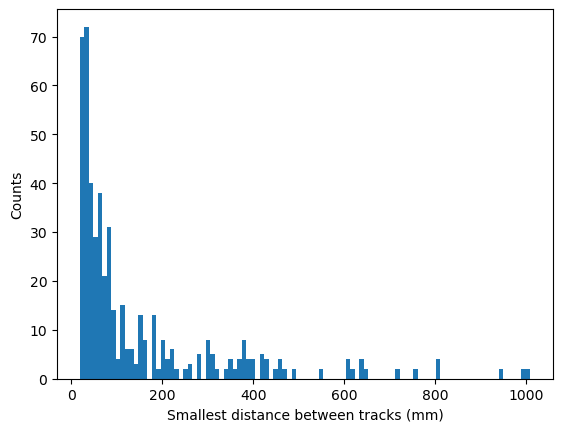

In [26]:
plt.hist(track_sep, bins = 100)
plt.xlabel("Smallest distance between tracks (mm)")
plt.ylabel("Counts")
plt.show()

Text(0.5, 0, 'Track lengths (mm)')

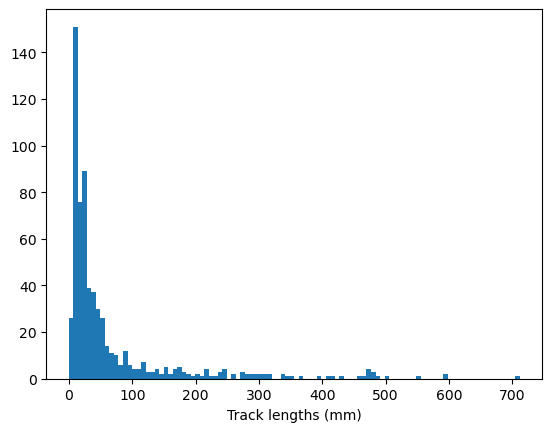

In [27]:
plt.hist(data.length, bins = 100)
plt.xlabel("Track lengths (mm)")

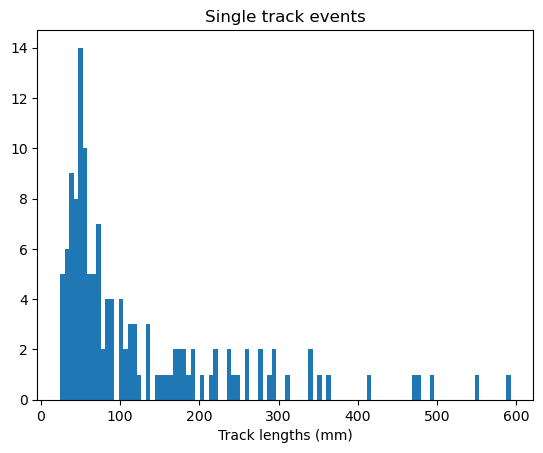

In [28]:
# lets look at single track lengths
plt.hist(data[data.numb_of_tracks == 1].length, bins = 100)
plt.xlabel("Track lengths (mm)")
plt.title("Single track events")
plt.show()

In [29]:
for i in range(-5, 5):
    print(i)

-5
-4
-3
-2
-1
0
1
2
3
4


### make a fake track with a bend, that means original dijkstra would fail where the new version wont 

In [30]:
# create x,y positions that will be redefined as hits below
xyze = []
xyze.append([0, 0, 0, 4]) # x pos, y pos, z pos, E
xyze.append([1, 1, 0, 1])
xyze.append([2, 2, 0, 1])
xyze.append([3, 3, 0, 1])
xyze.append([3, 4, 0, 1])
xyze.append([5, 4, 0, 1])
xyze.append([6, 4, 0, 1])
xyze.append([7, 4, 0, 1])
xyze.append([7, 6, 0, 20])
xyze.append([7, 3, 0, 1])
xyze.append([4, 5, 0, 1])
xyze.append([3, 6, 0, 1])
xyze.append([2, 7, 0, 1])
xyze.append([1, 8, 0, 1])
xyze.append([0, 6, 0, 10])


 # both tails are highly energetic


tr_1 = []
for num, i in enumerate(xyze):
    print(i)
    tr_1.append([0, 1, 9 * i[0] * units.mm, 9 * i[1] * units.mm, 9 * i[2] * units.mm, 1, i[3], i[3]])
    

data = pd.DataFrame(tr_1, columns = ['event', 'npeak', 'X', 'Y', 'Z', 'Q', 'E', 'Ep'])

display(data)

[0, 0, 0, 4]
[1, 1, 0, 1]
[2, 2, 0, 1]
[3, 3, 0, 1]
[3, 4, 0, 1]
[5, 4, 0, 1]
[6, 4, 0, 1]
[7, 4, 0, 1]
[7, 6, 0, 20]
[7, 3, 0, 1]
[4, 5, 0, 1]
[3, 6, 0, 1]
[2, 7, 0, 1]
[1, 8, 0, 1]
[0, 6, 0, 10]


,event,npeak,X,Y,Z,Q,E,Ep
0,0,1,0.0,0.0,0.0,1,4,4
1,0,1,9.0,9.0,0.0,1,1,1
2,0,1,18.0,18.0,0.0,1,1,1
3,0,1,27.0,27.0,0.0,1,1,1
4,0,1,27.0,36.0,0.0,1,1,1
5,0,1,45.0,36.0,0.0,1,1,1
6,0,1,54.0,36.0,0.0,1,1,1
7,0,1,63.0,36.0,0.0,1,1,1
8,0,1,63.0,54.0,0.0,1,20,20
9,0,1,63.0,27.0,0.0,1,1,1


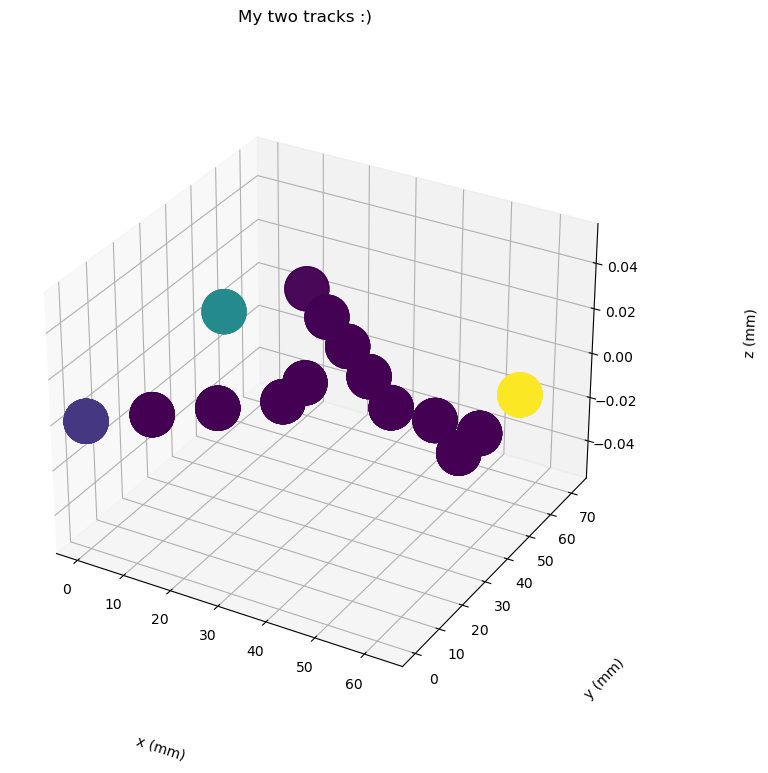

In [31]:
plt.ion()
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
for Y, df in data.groupby(['Y']):
    ax.scatter(data.X, data.Y, data.Z, c=data.E, s=1000, label = f'{Y}')
ax.set_xlabel("x (mm)", labelpad=50)
ax.set_ylabel("y (mm)", labelpad=50)
ax.set_zlabel("z (mm)", labelpad=50)
plt.suptitle("My two tracks :)")

plt.show()

/tmp/ipykernel_207809/3444354541.py:53: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


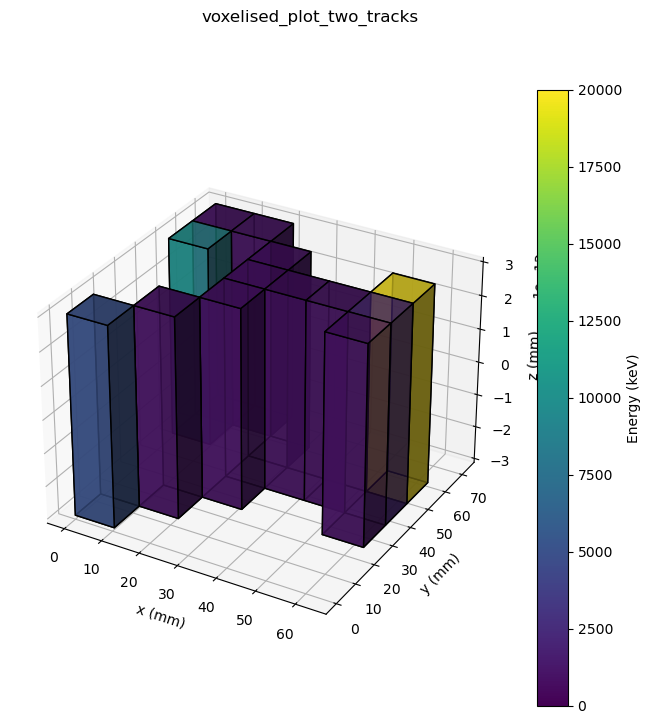

In [32]:
plot_voxels(data)

In [33]:
topological_creator = track_blob_info_creator_extractor((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        27 * units.mm,
                                                        1000000,
                                                        True
                                                        )

old_topological_creator = track_blob_info_creator_extractor((12 * units.mm, 12 * units.mm, 12 * units.mm),
                                                        False,
                                                        10 * units.keV,
                                                        3,
                                                        27 * units.mm,
                                                        1000000,
                                                        False
                                                        )

In [34]:
hits_lol = hits_from_df(data)

df, track_hitc, out_of_map = topological_creator(hits_lol[0])
display(df)

plt.ion()
ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
for Y, dfs in data.groupby(['Y']):
    ax.scatter(data.X, data.Y, data.Z, c=data.E, s=1000)#, label = f'{Y}', zorder = 0)
ax.set_xlabel("x (mm)", labelpad=50)
ax.set_ylabel("y (mm)", labelpad=50)
ax.set_zlabel("z (mm)", labelpad=50)


x_b1 = df.blob1_x
y_b1 = df.blob1_y
z_b1 = df.blob1_z

print(df.blob1_x.values, df.blob1_y.values, df.blob1_z.values)
print(df.blob2_x.values, df.blob2_y.values, df.blob2_z.values)

x_b2 = df.blob2_x
y_b2 = df.blob2_y
z_b2 = df.blob2_z


ax.scatter3D(x_b1, y_b1, z_b1, s = 2000, c = 'red', marker = 'x', zorder = 100, label = 'predicted blob1', depthshade=False)
ax.scatter3D(x_b2, y_b2, z_b2, s = 2000, c = 'green', marker = 'x', zorder = 100, label = 'predicted blob2', depthshade=False)
plt.legend()
plt.show()

Distance retrieved: {Voxel(5.2499999999975, 5.9999999999975, 0.0, E=5.0): {Voxel(5.2499999999975, 5.9999999999975, 0.0, E=5.0): 0, Voxel(5.2499999999975, 54.000000000001506, 0.0, E=10.0): 87.78087487641554, Voxel(5.2499999999975, 66.0000000000025, 0.0, E=1.0): 82.33565615731317, Voxel(15.7499999999985, 17.9999999999985, 0.0, E=1.0): 15.945218719103387, Voxel(15.7499999999985, 66.0000000000025, 0.0, E=1.0): 71.83565615731216, Voxel(26.249999999999503, 29.999999999999503, 0.0, E=1.0): 31.890437438206774, Voxel(26.249999999999503, 42.0000000000005, 0.0, E=1.0): 43.89043743820777, Voxel(26.249999999999503, 54.000000000001506, 0.0, E=1.0): 55.89043743820878, Voxel(36.7500000000005, 42.0000000000005, 0.0, E=1.0): 47.835656157310154, Voxel(47.250000000001506, 42.0000000000005, 0.0, E=1.0): 58.33565615731116, Voxel(57.7500000000025, 29.999999999999503, 0.0, E=1.0): 74.28087487641454, Voxel(57.7500000000025, 42.0000000000005, 0.0, E=2.0): 68.83565615731216, Voxel(57.7500000000025, 54.0000000000

KeyError: None